In [70]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image               # provides extensive support for working with images
import cv2
import pickle

# LOADING DATASET

In [71]:
def test_load(file):
    try:
        with open(file, 'rb') as f:
            d = pickle.load(f, encoding='latin1')
            print(f"Loaded {file} successfully.")
    except Exception as e:
        print(f"Error loading {file}: {e}")

test_load('train.p')
test_load('test.p')
test_load('valid.p')


Loaded train.p successfully.
Loaded test.p successfully.
Loaded valid.p successfully.


In [72]:
def inspect_file(file):
    # Open the pickled file
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='latin1')

    # Check the type and contents
    print("Type of data:", type(data))
    print("Keys in data:", data.keys())

inspect_file("train.p")

Type of data: <class 'dict'>
Keys in data: dict_keys(['coords', 'labels', 'features', 'sizes'])


In [73]:
def load_rgb_data(file):
    # Opening 'pickle' file and getting images
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')     # 'latin1' for compatibility with Python 3
        x = d['features']   # 4D numpy.ndarray type
        y = d['labels']     # 1D numpy.ndarray type
        s = d['sizes']      # 2D numpy.ndarray type
        c = d['coords']     # 2D numpy.ndarray type

    return x, y, s, c

# Load the data from the uploaded files
train_f, train_l, train_s, train_c = load_rgb_data('train.p')
test_f, test_l, test_s, test_c = load_rgb_data('test.p')
valid_f, valid_l, valid_s, valid_c = load_rgb_data('valid.p')


In [74]:
# Defining function for getting texts for every class - labels
def label_text(file):
    df = pd.read_csv(file)
    label_list = df['SignName'].tolist()

    print(label_list)

    return label_list

labels = label_text("signname.csv")

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric']


# DATA VISUALIZATION

Class Name: Speed limit (20km/h)


<Figure size 1400x1400 with 0 Axes>

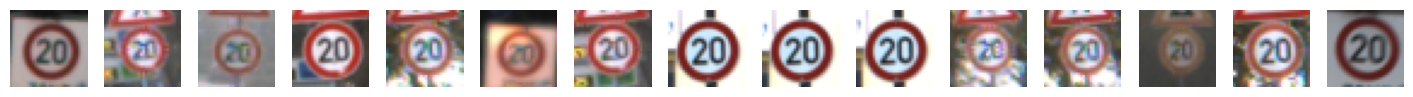

Class Name: Speed limit (30km/h)


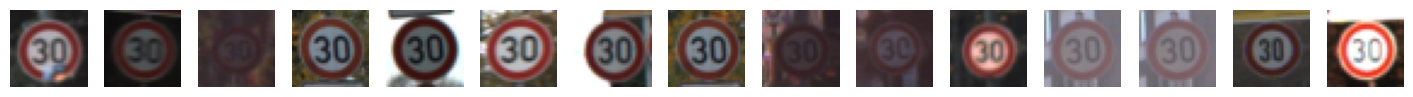

Class Name: Speed limit (50km/h)


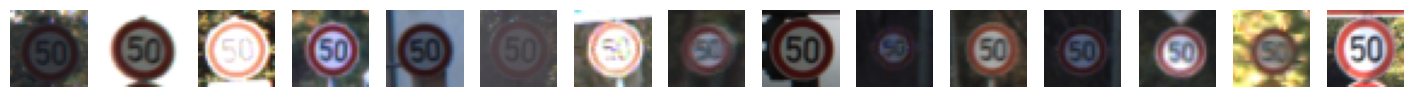

Class Name: Speed limit (60km/h)


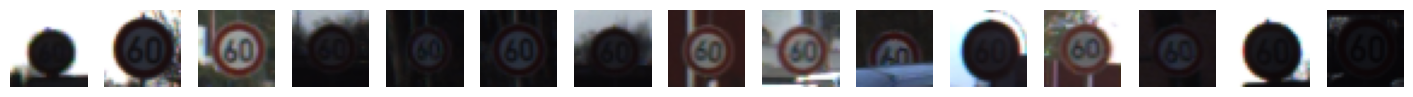

Class Name: Speed limit (70km/h)


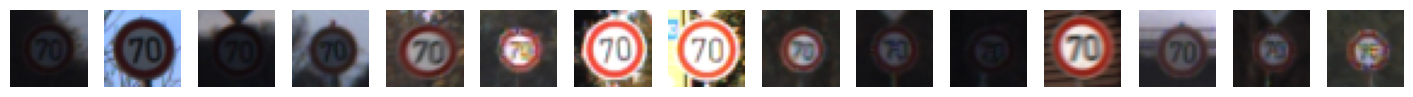

Class Name: Speed limit (80km/h)


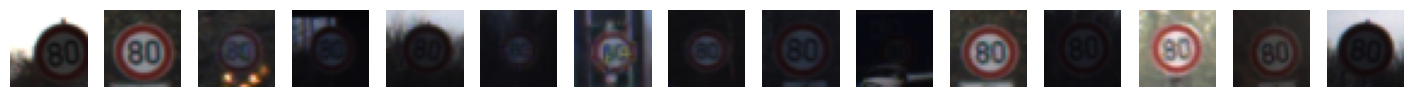

Class Name: End of speed limit (80km/h)


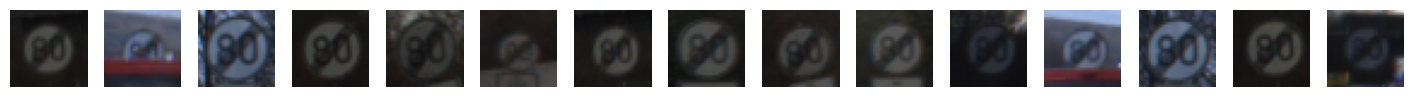

Class Name: Speed limit (100km/h)


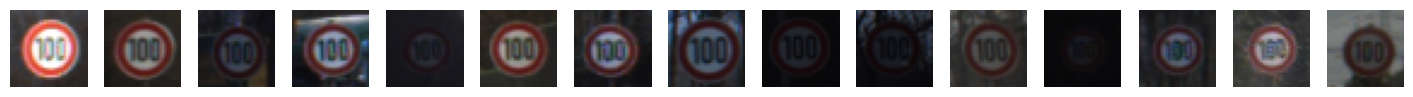

Class Name: Speed limit (120km/h)


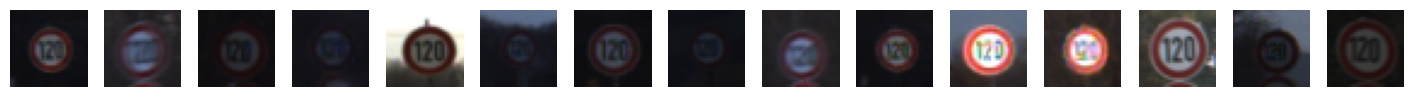

Class Name: No passing


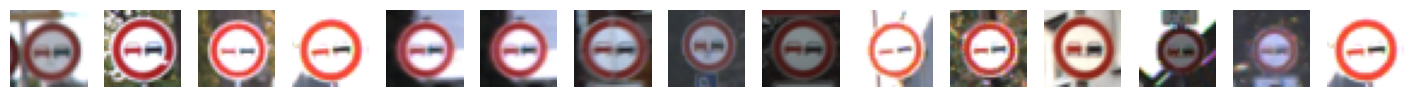

Class Name: No passing for vehicles over 3.5 metric tons


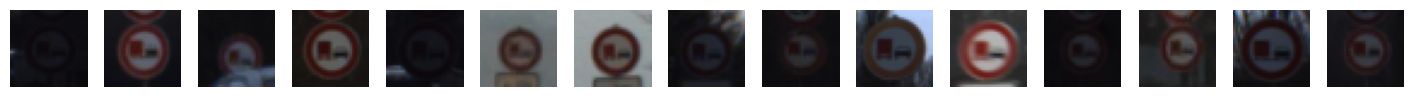

Class Name: Right-of-way at the next intersection


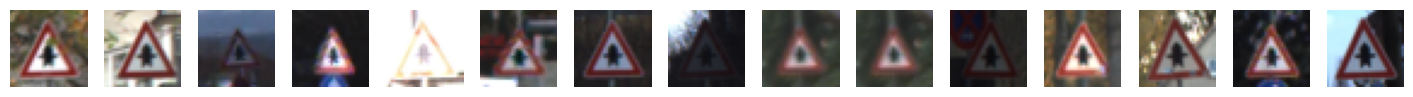

Class Name: Priority road


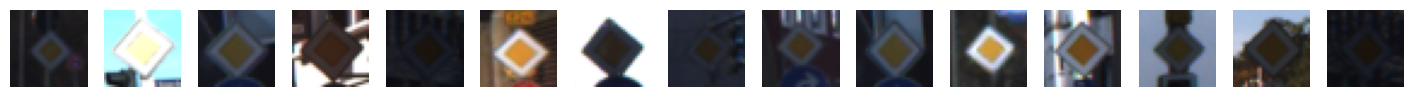

Class Name: Yield


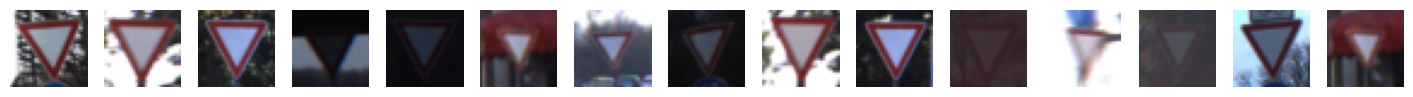

Class Name: Stop


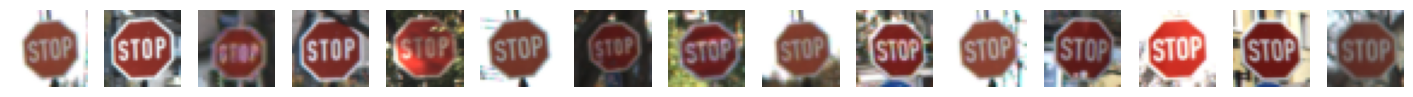

Class Name: No vehicles


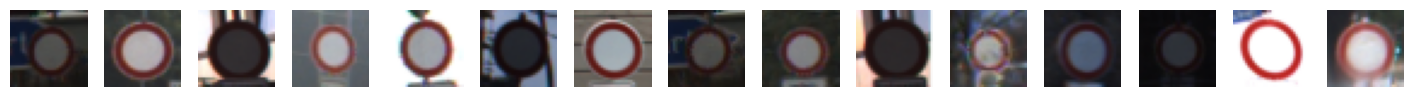

Class Name: Vehicles over 3.5 metric tons prohibited


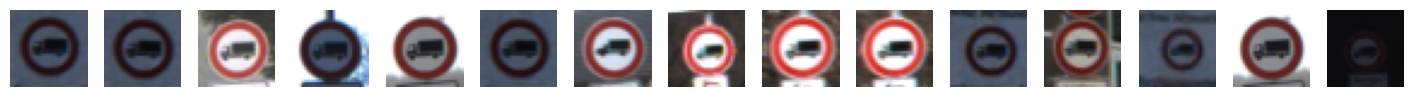

Class Name: No entry


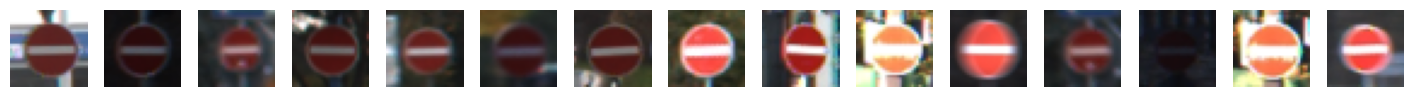

Class Name: General caution


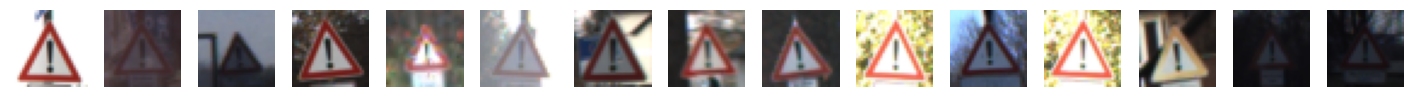

Class Name: Dangerous curve to the left


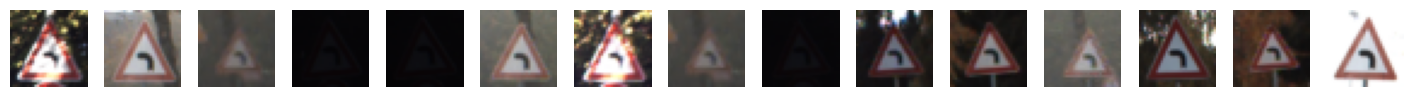

Class Name: Dangerous curve to the right


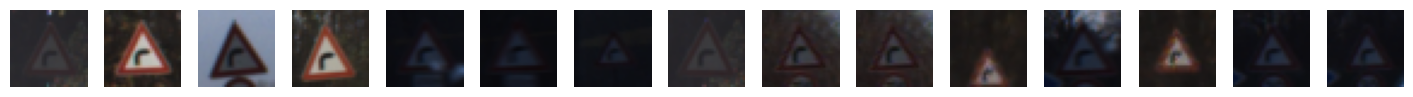

Class Name: Double curve


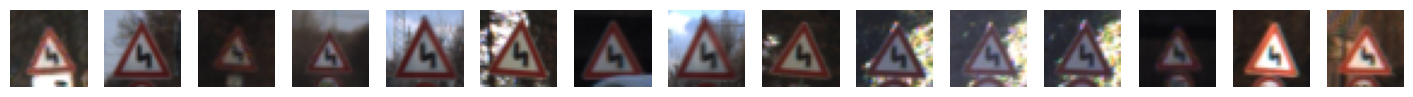

Class Name: Bumpy road


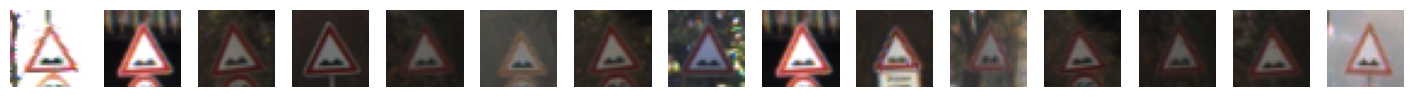

Class Name: Slippery road


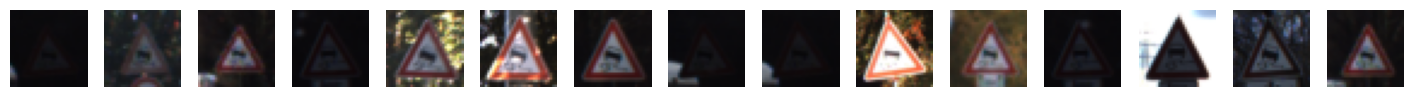

Class Name: Road narrows on the right


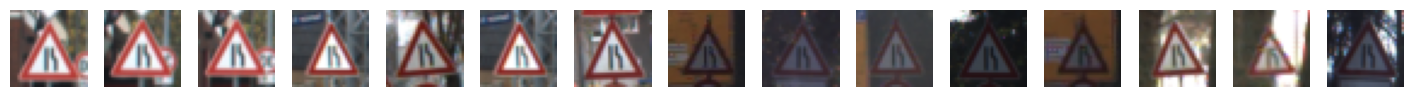

Class Name: Road work


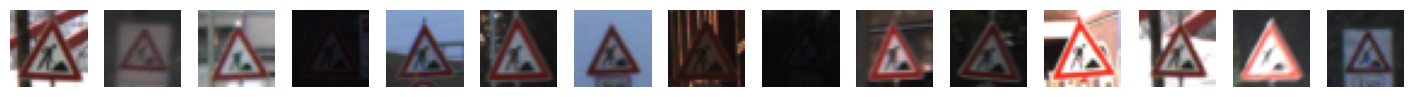

Class Name: Traffic signals


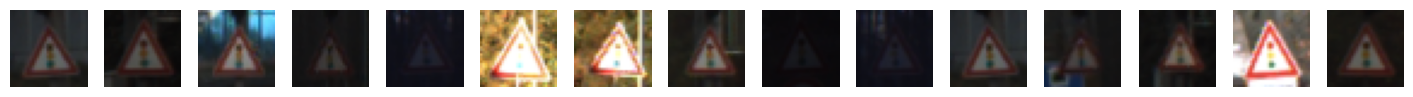

Class Name: Pedestrians


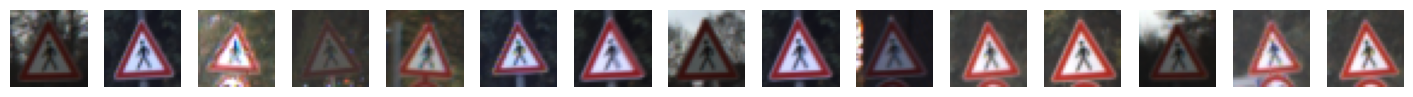

Class Name: Children crossing


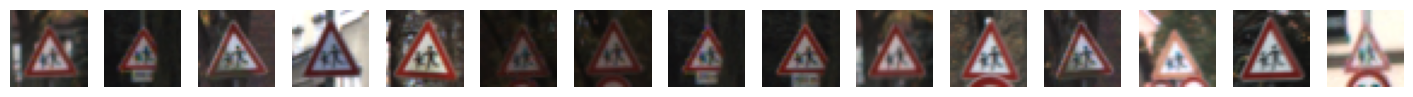

Class Name: Bicycles crossing


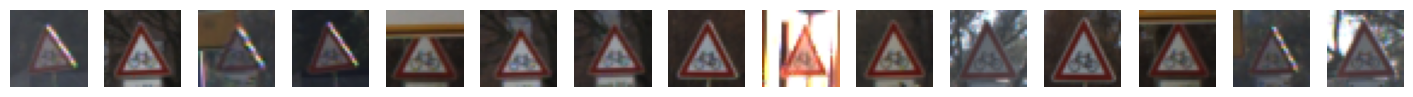

Class Name: Beware of ice/snow


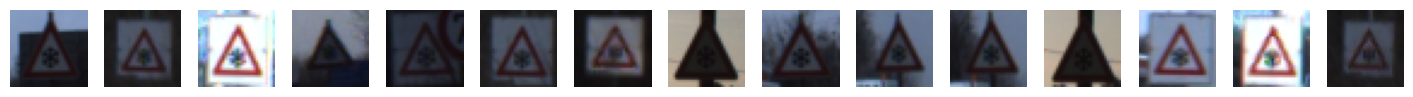

Class Name: Wild animals crossing


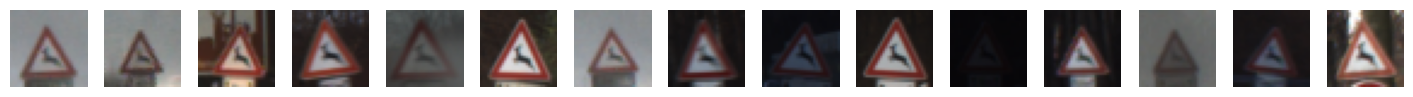

Class Name: End of all speed and passing limits


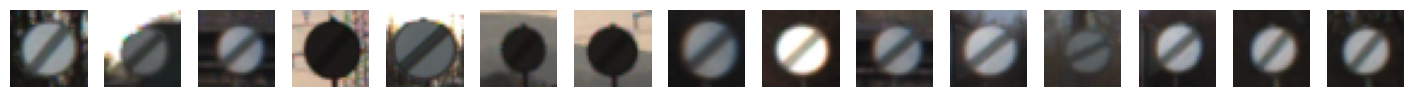

Class Name: Turn right ahead


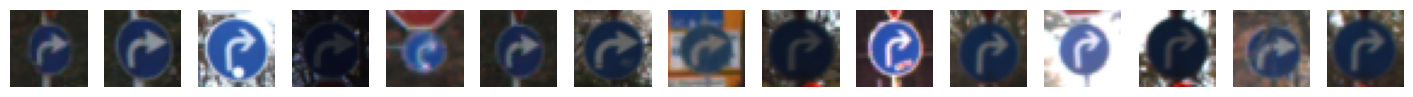

Class Name: Turn left ahead


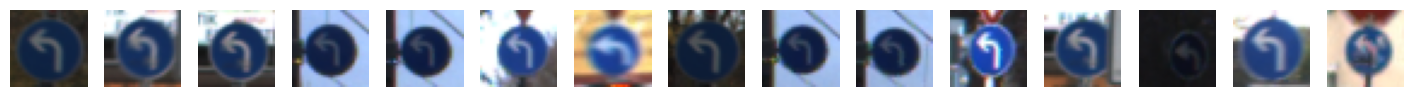

Class Name: Ahead only


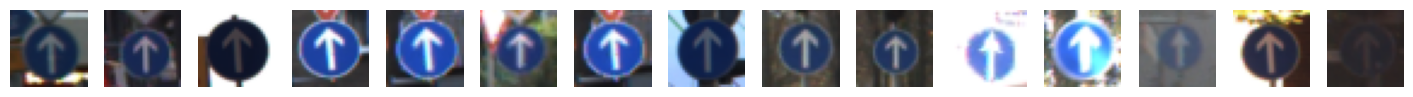

Class Name: Go straight or right


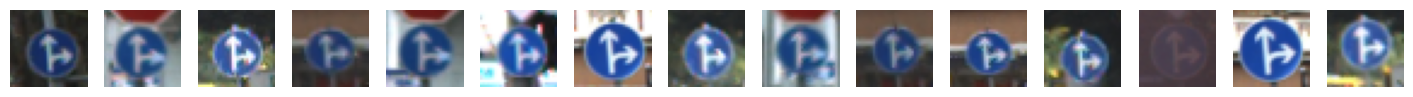

Class Name: Go straight or left


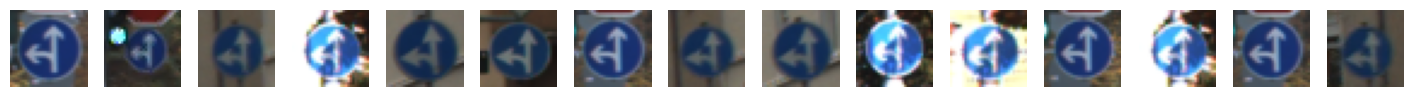

Class Name: Keep right


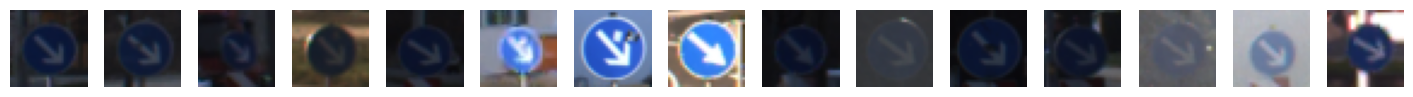

Class Name: Keep left


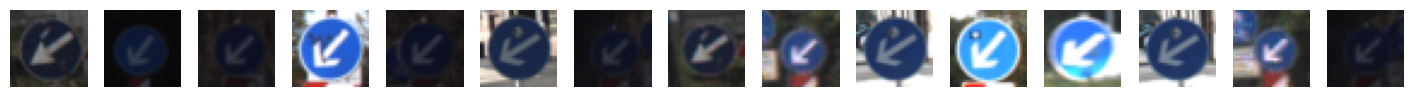

Class Name: Roundabout mandatory


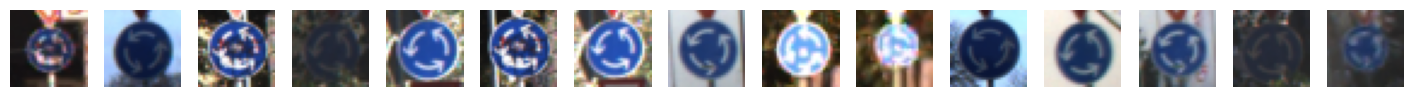

Class Name: End of no passing


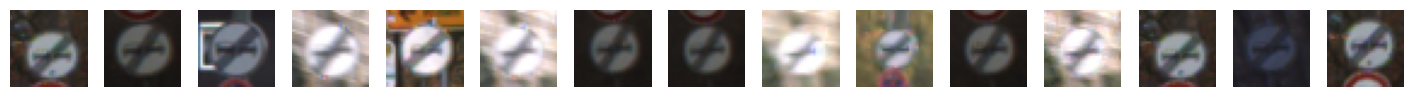

Class Name: End of no passing by vehicles over 3.5 metric


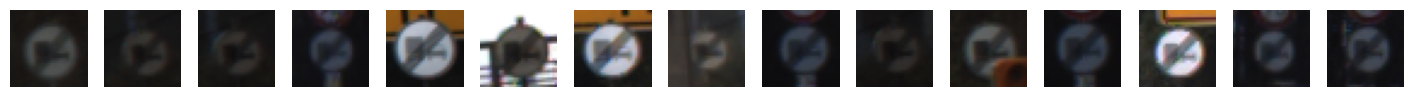

In [75]:
# Getting no. of Unique elements with their no. of occurances and indices in the original array
classes, class_indices, class_counts  = np.unique(train_l, return_index=True, return_counts=True)

def plot_images(images, labels):
    plt.figure(figsize = (14, 14))

    for c, c_i, c_count in zip(classes, class_indices, class_counts):
        print(f"Class Name: {labels[c]}")
        fig = plt.figure(figsize = (18, 1))

        for i in range(15):
            plt.subplot(1,15, i+1)
            plt.imshow(images[np.random.randint(c_i, c_i + c_count, 15)[i],:,:,:])
            plt.axis("off")
        plt.show()

plot_images(train_f, labels)

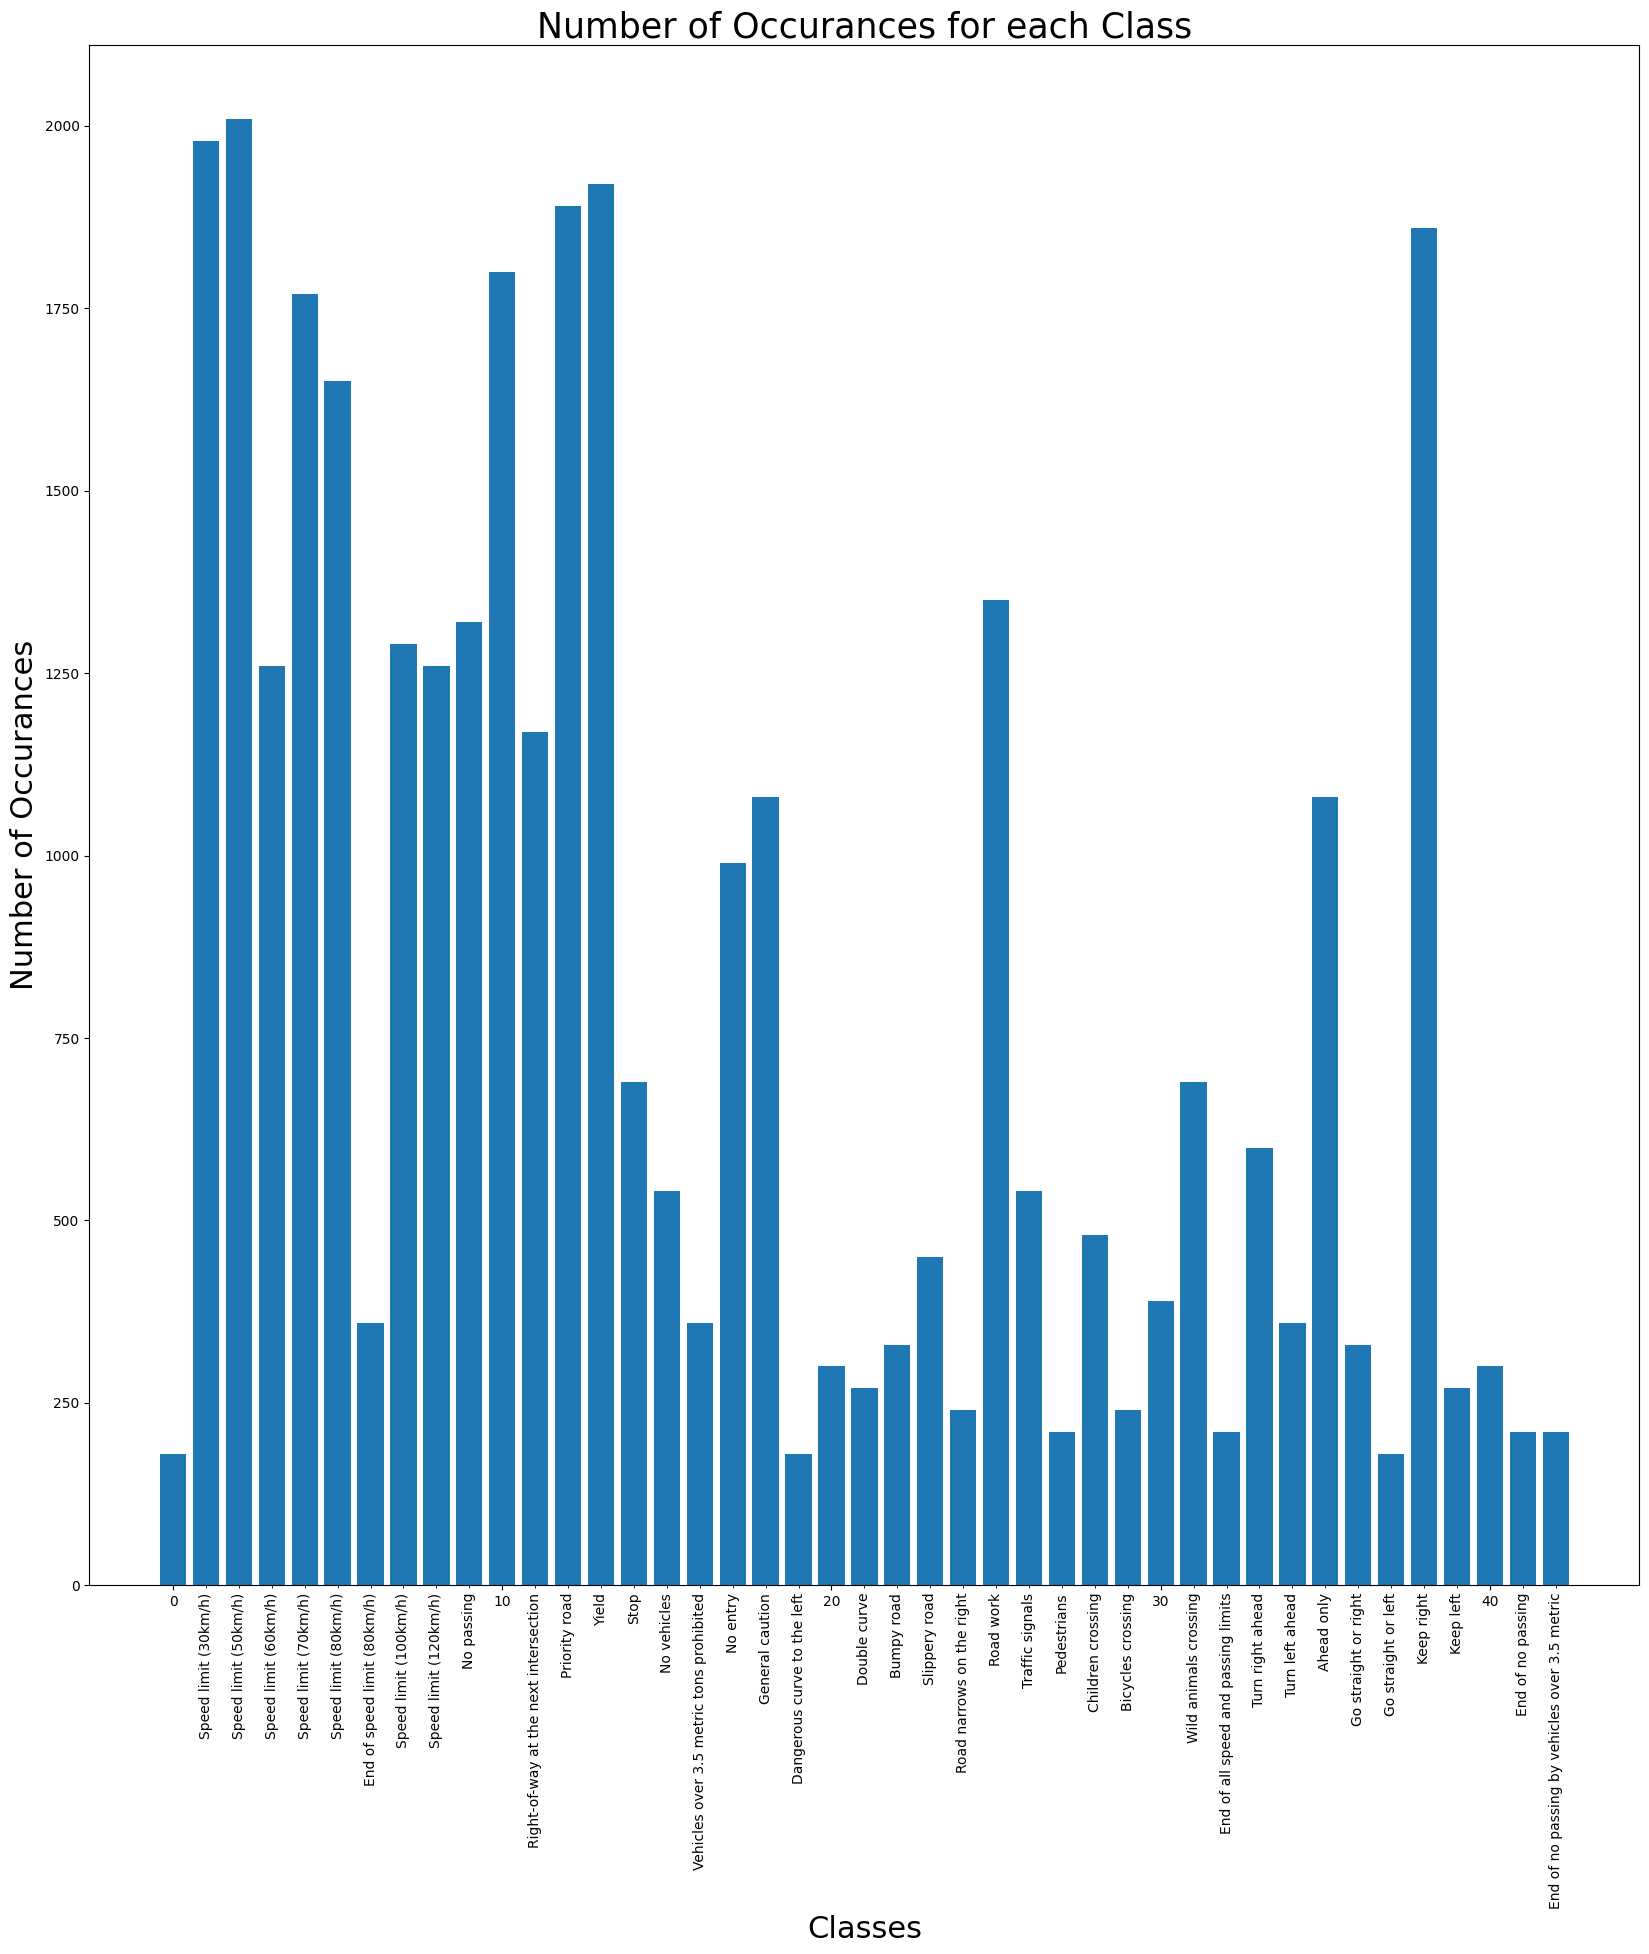

In [76]:
plt.figure(figsize = (20,20))
plt.bar(classes, class_counts)

plt.title('Number of Occurances for each Class', fontsize=25)
plt.xlabel('Classes', fontsize=22)
plt.ylabel('Number of Occurances', fontsize=22)
plt.xticks(classes, labels , minor = True, rotation = 90)
plt.show()

# DATA AUGMENTATION

In [77]:
# Convert labels to one-hot encoding
train_l = to_categorical(train_l, num_classes=43)
valid_l = to_categorical(valid_l, num_classes=43)
test_l = to_categorical(test_l, num_classes=43)

In [78]:
train_l

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [79]:
image_generator = ImageDataGenerator(rescale = 1/255)
train_data = image_generator.flow(train_f,train_l,
                                  batch_size = 43)
valid_data = image_generator.flow(valid_f, valid_l,
                                  batch_size = 43)
test_data = image_generator.flow(test_f,test_l,
                                  batch_size = 43)
print(train_f.shape)
print(train_l.shape)

(34799, 32, 32, 3)
(34799, 43)


# MODEL BUILDING

In [80]:
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters = 16,
                 kernel_size = 3,
                 padding = "same",
                 activation = "relu",
                 input_shape = [32, 32, 3])
         )


model.add(Conv2D(filters = 32,
                 kernel_size = 3,
                 padding = "same",
                 activation = "relu",
                 input_shape = [32, 32, 3])
         )

# Pooling Layer
model.add(MaxPooling2D(pool_size = (2,2)))

# Batch Normalization
model.add(BatchNormalization(axis=-1))               # applies normalization across channels.

# Convolutional Layer
model.add(Conv2D(filters = 64,
                 kernel_size = 3,
                 padding = "same",
                 activation = "relu",)
         )

model.add(Conv2D(filters = 128,
                 kernel_size = 3,
                 padding = "same",
                 activation = "relu",)
         )


model.add(MaxPooling2D(pool_size = (2,2)))

model.add(BatchNormalization(axis=-1))

# Dropout Layer to prevent overfitting
model.add(Dropout(0.1))


# CLASSIFICATION

# Flatten Layer
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation = "relu"))
model.add(Dense(128, activation = "relu"))

# Output Layer
model.add(Dense(43, activation = "softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,168,843 (4.46 MB)

 Trainable params: 1,168,523 (4.46 MB)

 Non-trainable params: 320 (1.25 KB)

# MODEL COMPILATION AND FITTING

In [82]:
model.compile(optimizer = "adam",
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [83]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode, 1 = progress bar
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [84]:
model_history = model.fit(x = train_data,
                         epochs = 20,
                         validation_data = valid_data,
                         callbacks = [early_stopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7567 - loss: 0.9378 - val_accuracy: 0.9383 - val_loss: 0.2169
Epoch 2/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9891 - loss: 0.0372 - val_accuracy: 0.9147 - val_loss: 0.3196
Epoch 3/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9921 - loss: 0.0248 - val_accuracy: 0.9107 - val_loss: 0.3619
Epoch 4/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9911 - loss: 0.0317 - val_accuracy: 0.9327 - val_loss: 0.2974
Epoch 5/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9950 - loss: 0.0187 - val_accuracy: 0.9458 - val_loss: 0.2442
Epoch 6/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9938 - loss: 0.0190 - val_accuracy: 0.9569 - val_loss: 0.2038
Epoch 7/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9946 - loss: 0.0184 - val_accuracy: 0.9587 - val_loss: 0.2162
Epoch 8/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9956 - loss: 0.0172 - val_accuracy: 0.9741 - v

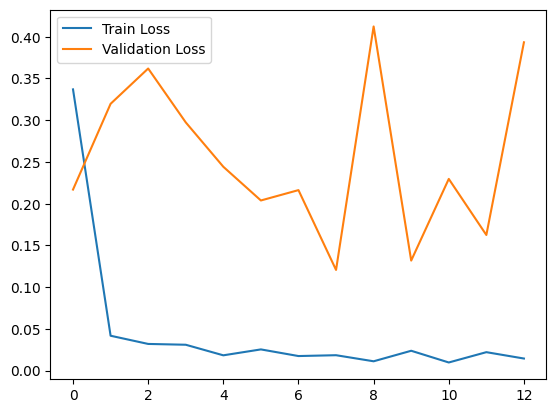

In [85]:
plt.plot(model_history.history["loss"], label = "Train Loss")
plt.plot(model_history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

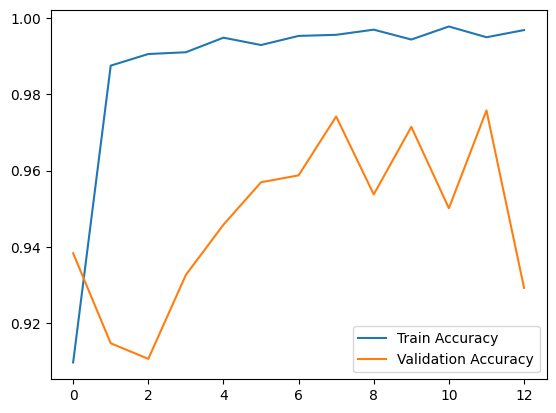

In [86]:
plt.plot(model_history.history["accuracy"], label = "Train Accuracy")
plt.plot(model_history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

In [87]:
model.evaluate(test_data)

294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9637 - loss: 0.2249


[0.22509607672691345, 0.9634996056556702]

In [88]:
model.evaluate(train_data)

810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9995 - loss: 0.0018


[0.002126284409314394, 0.9994540214538574]

In [89]:
model.save('model.h5')


In [90]:
def prediction(test_file, model):
    x_test, y_test, _, _ = load_rgb_data(test_file)

    # Define the data generator with shuffling enabled
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow(x_test, y_test, batch_size=43, shuffle=True)

    # Collect predictions and corresponding true labels
    y_pred = []
    y_true = []

    for i in range(len(generator)):
        batch_x, batch_y = generator[i]
        batch_pred = model.predict(batch_x)
        batch_pred_classes = np.argmax(batch_pred, axis=1)

        y_pred.extend(batch_pred_classes)
        y_true.extend(batch_y)

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    print(y_pred)

    # Generate classification report
    print(classification_report(y_true, y_pred, target_names=labels))

    unique_labels = np.unique(y_true)
    return confusion_matrix(y_true, y_pred, labels=unique_labels)


cm = prediction("test.p", model)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━

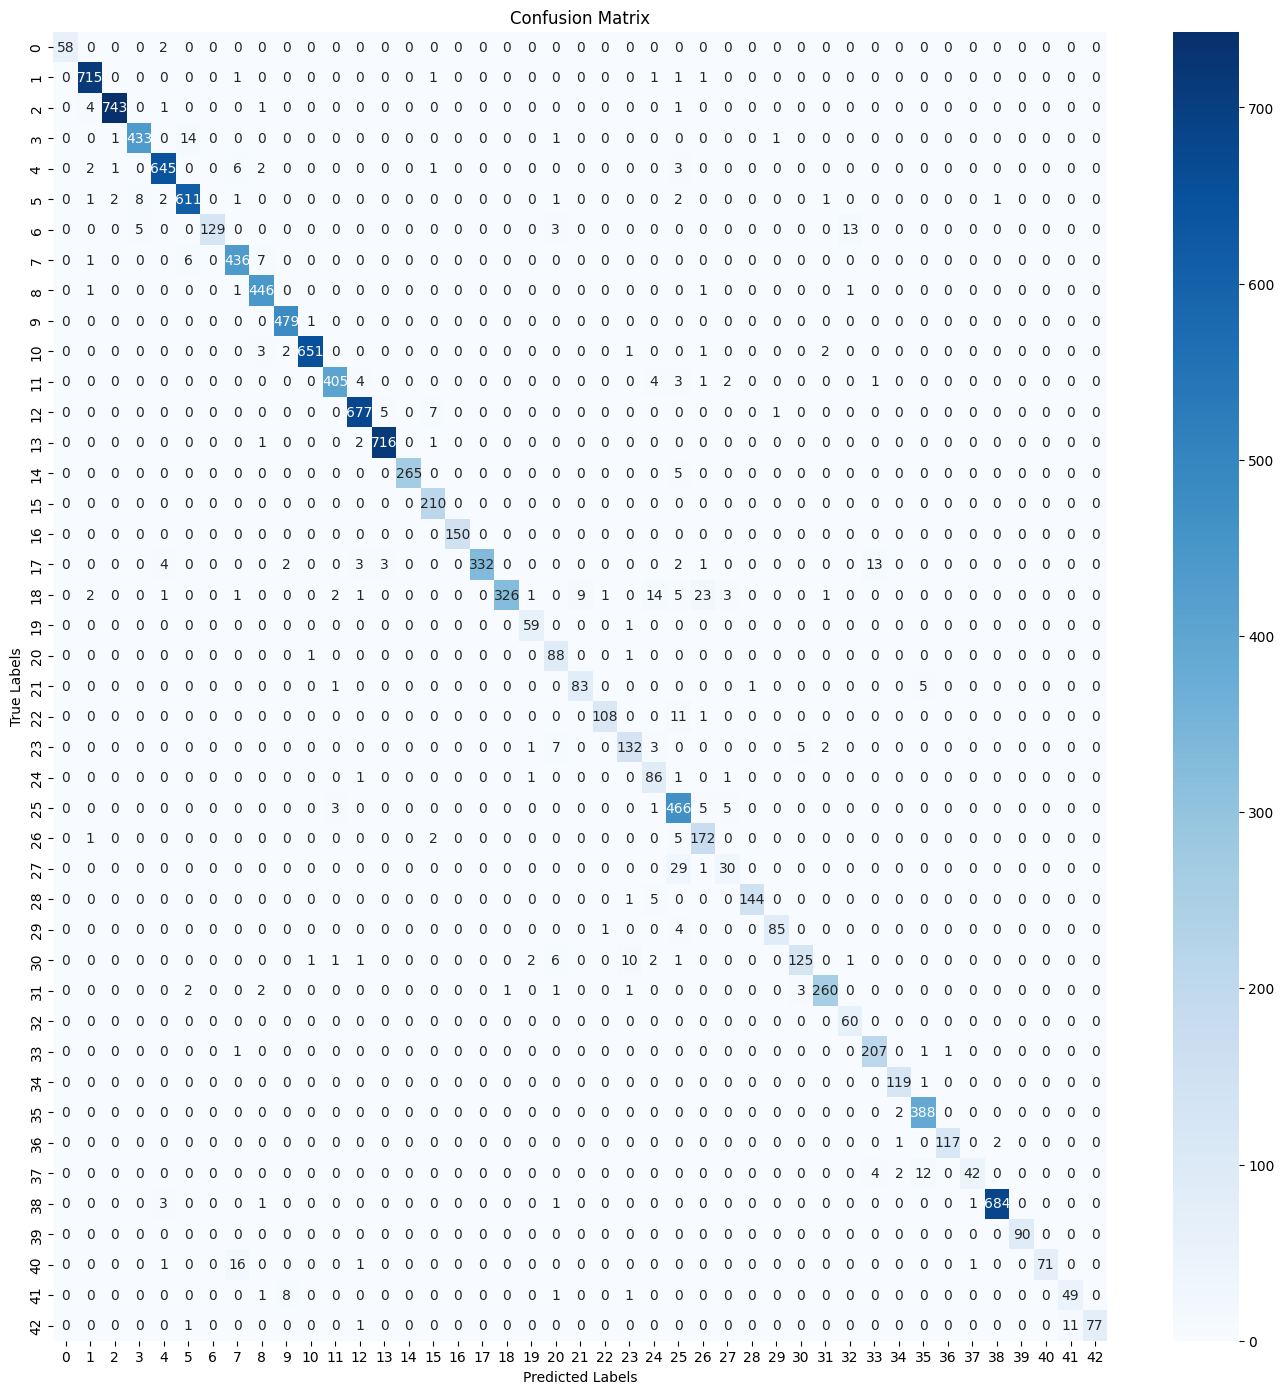

In [91]:
plt.figure(figsize=(17, 17))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# PREDICTING NEW IMAGES

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


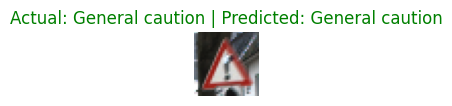

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


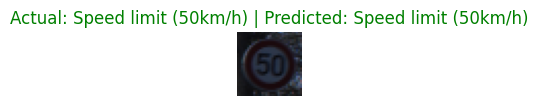

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


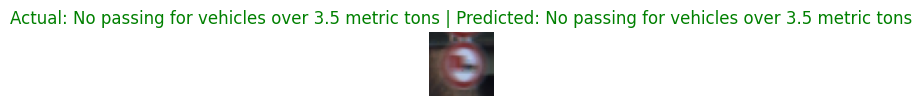

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


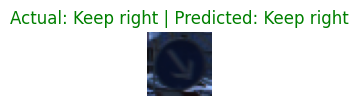

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


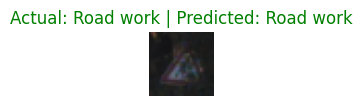

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


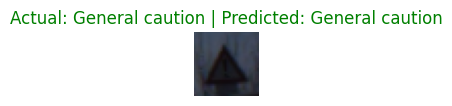

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


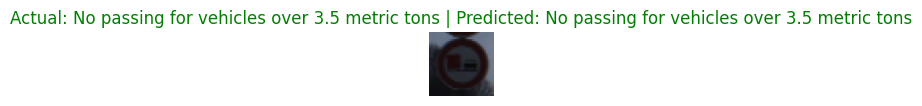

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


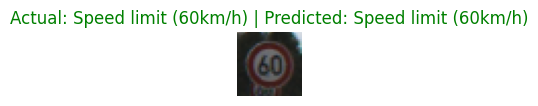

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


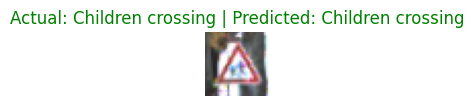

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


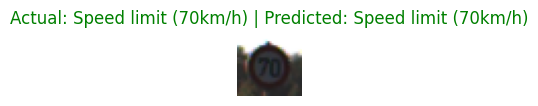

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


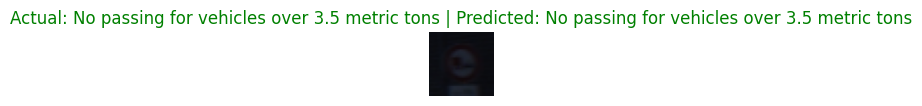

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


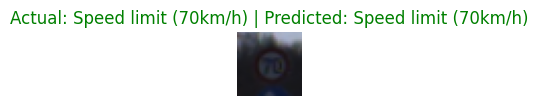

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


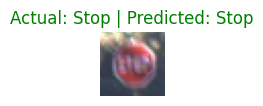

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


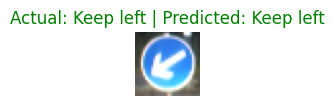

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


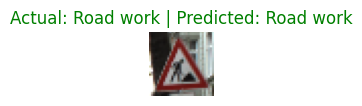

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


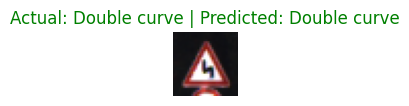

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


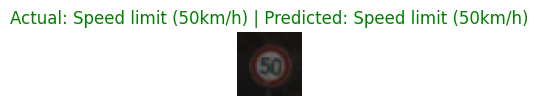

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


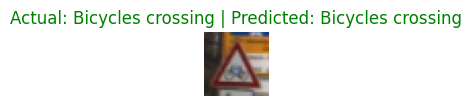

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


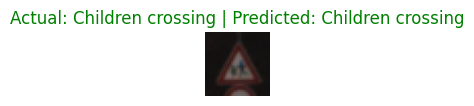

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


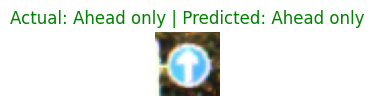

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


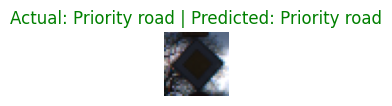

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


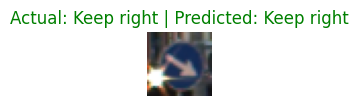

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


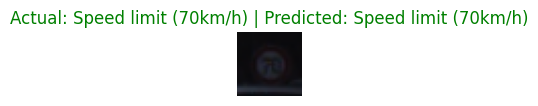

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


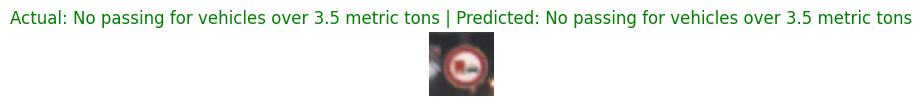

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


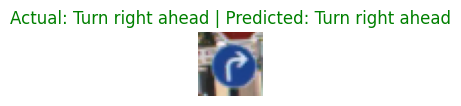

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


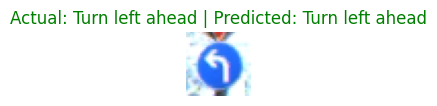

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


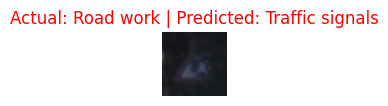

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


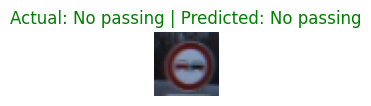

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


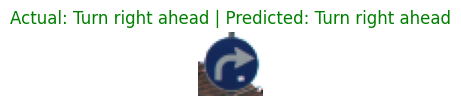

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


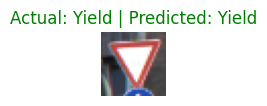

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


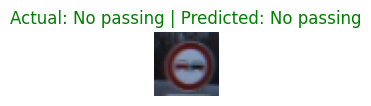

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


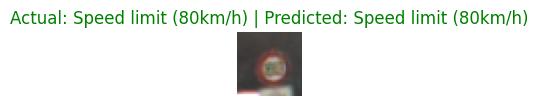

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


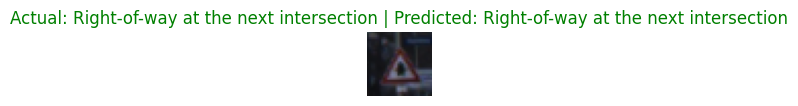

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


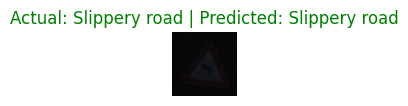

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


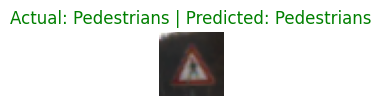

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


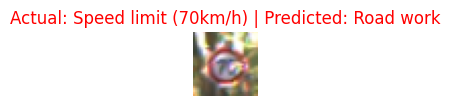

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


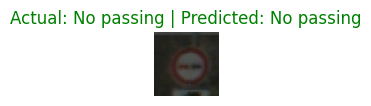

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


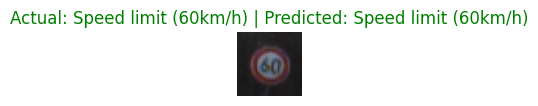

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


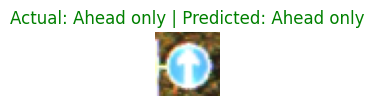

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


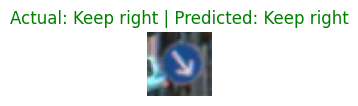

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


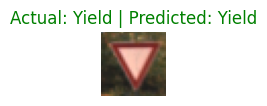

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


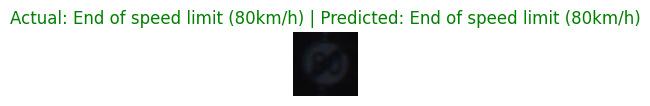

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


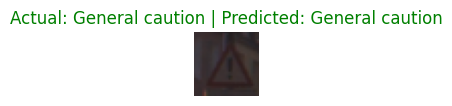

In [93]:
def prediction(test_file):

     with open(test_file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')
        x = d['features']
        y = d['labels']

        classes_test, class_indices_test, class_counts_test  = np.unique(y, return_index=True, return_counts=True)
        # Visulize the Predicited Image
        for c, c_i, c_count in zip(classes_test, class_indices_test, class_counts_test):
            fig = plt.figure(figsize = (43, 43))

            plt.subplot(43,1, c+1)
            idx = np.random.randint(c_i, c_i + c_count)
            img = x[idx]

            # Rescale image as done in the image generator
            img_rescaled = img.astype('float32') / 255

            prediction = model.predict(np.expand_dims(img_rescaled, axis=0))
            predicted_class = np.argmax(prediction, axis=1)

            plt.imshow(img_rescaled)

            actual_label = labels[np.where(np.array(classes_test) == y[idx])[0][0]]  # Find the actual label
            col = 'green' if actual_label == labels[predicted_class[0]] else 'red'
            plt.title(f"Actual: {actual_label} | Predicted: {labels[predicted_class[0]]}", color=col)
            plt.axis("off")
            plt.axis("off")
            plt.show()

prediction("test.p")